# Normalisation of dataset

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
import numpy as np
import torch
from dataio.transformation.imageTransformations import StandardizeImage
from gsprep.visual_tools.dataset_histograms import plot_dataset_histogram, plot_per_sample_histograms

In [2]:
dataset_path = '/Users/julian/temp/perfusion_data_sets/rescaled_data_set.npz'
n_subj = 144

raw_images = np.load(dataset_path, allow_pickle=True)['ct_inputs'][:n_subj].astype(np.float64)
raw_labels = np.load(dataset_path, allow_pickle=True)['ct_lesion_GT'][:n_subj].astype(np.uint8)
# raw_labels = np.load(dataset_path, allow_pickle=True)['lesion_GT'][:n_subj].astype(np.float64)
raw_mask = np.load(dataset_path, allow_pickle=True)['brain_masks'][:n_subj]
params = np.load(dataset_path, allow_pickle=True)['params']

n_subj, n_x, n_y, n_z, n_c = raw_images.shape
raw_images.shape

(144, 79, 95, 79, 4)

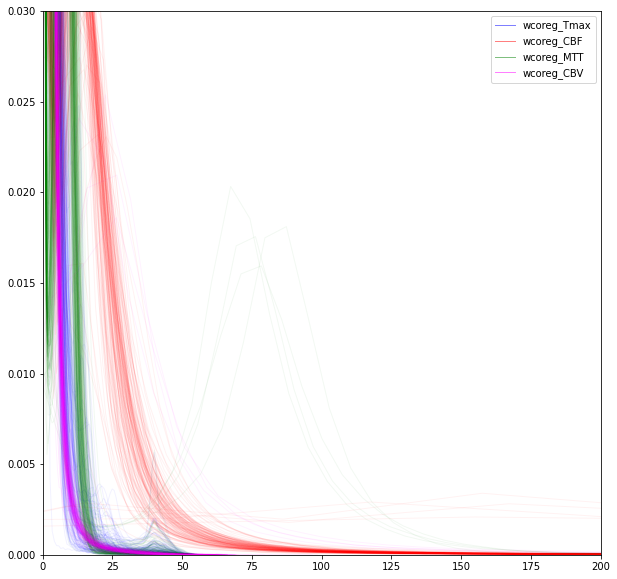

In [3]:
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1)
n_subj, n_x, n_y, n_z, n_c = raw_images.shape
color_scheme = ['blue', 'red', 'green', 'magenta']
ct_sequences = params.item()['ct_sequences']

for index, (channel, color, label) in enumerate(zip(range(n_c), color_scheme, ct_sequences)):
    plot_dataset_histogram(raw_images[:, ..., channel], num_positions=100, color=color, mask_zero=True, axis=axis,
                           dataset_label=label)
axis.set_xlim(0, 200)
axis.set_ylim(0, 0.03)
leg = axis.legend()
for lh in leg.legendHandles:
    lh.set_alpha(0.5)

Original data histograms


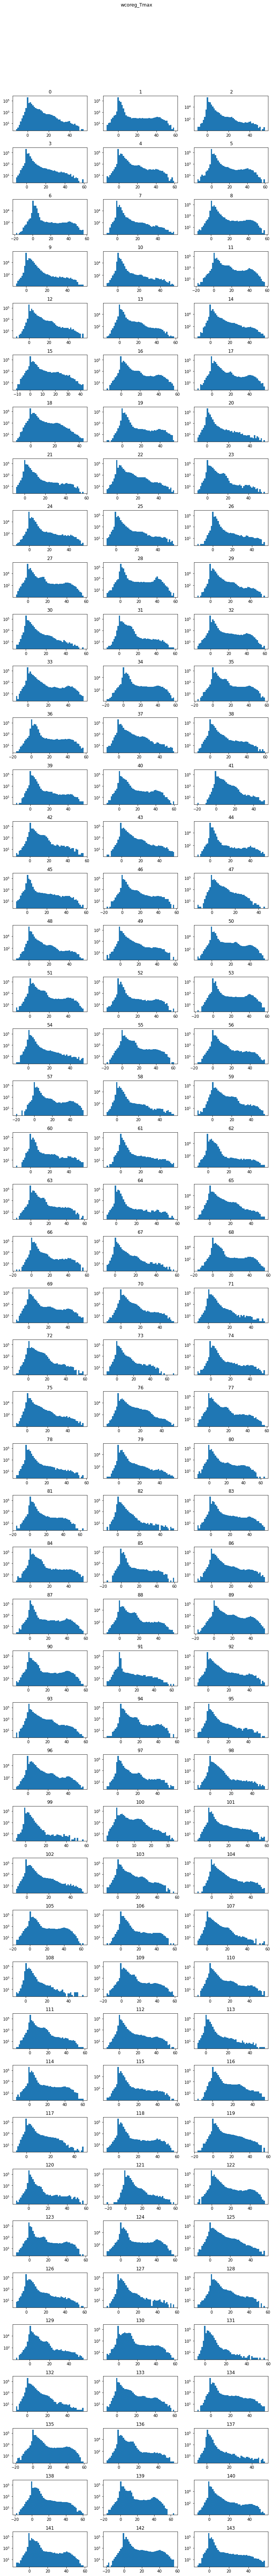

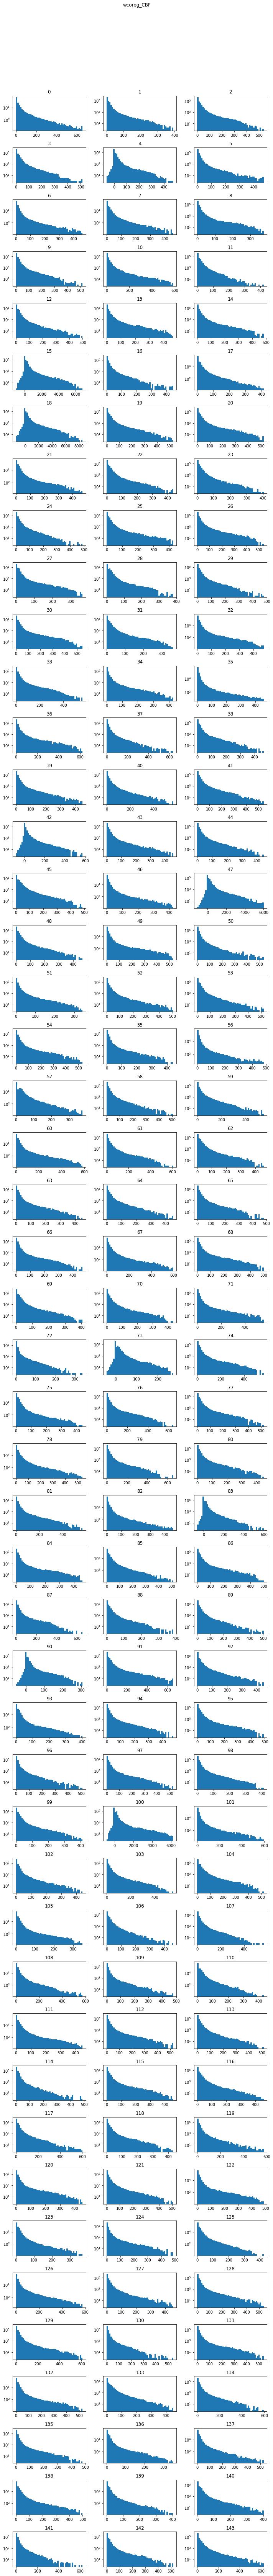

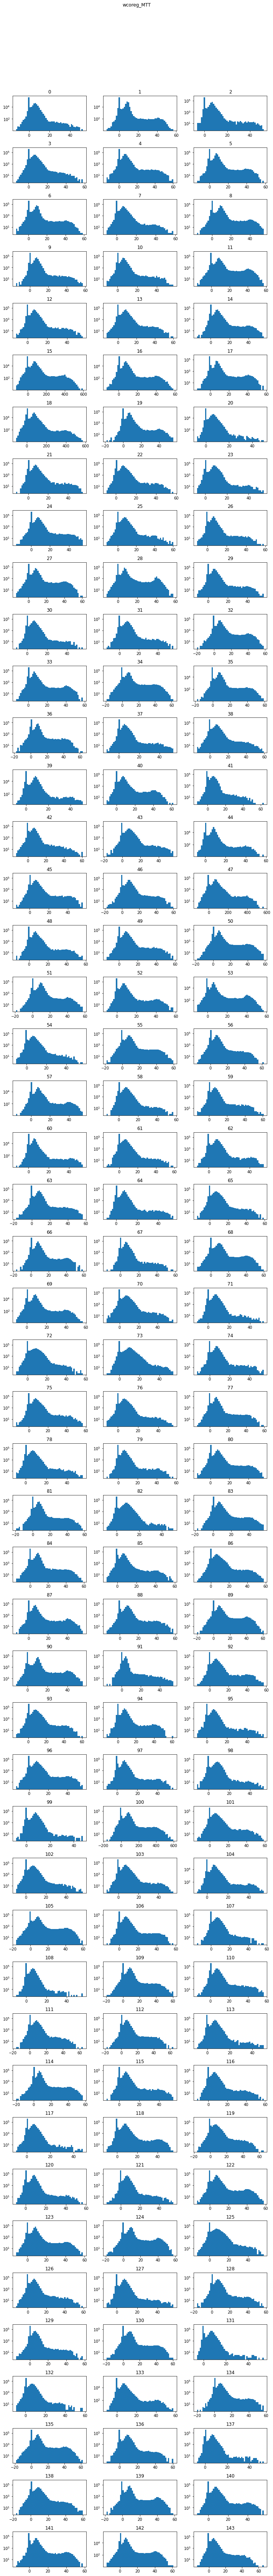

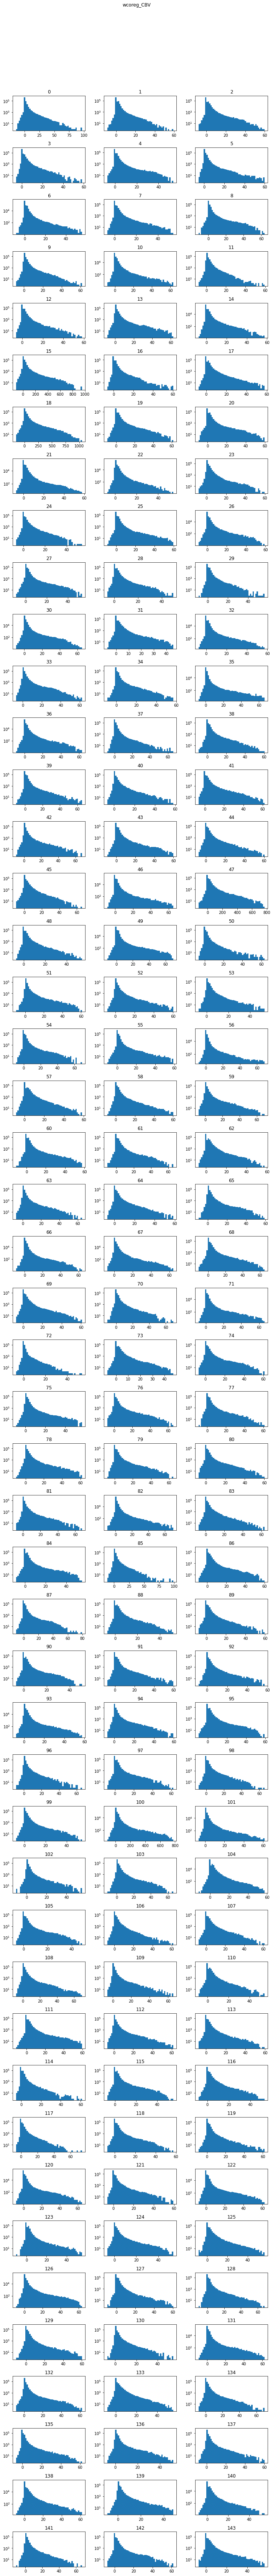

In [4]:
for index, (channel, label) in enumerate(zip(range(n_c), ct_sequences)):
    plot_per_sample_histograms(raw_images[..., channel], log=True, title=label, figsize=(10, 100))
print("Original data histograms")

## Standardisation
Normalises given volume to zero mean and unit standard deviation.



### Subject wise standardisation

In [5]:
# Mimic the way it is called in transformations
def apply_standardisation(input, target):
    transform = StandardizeImage(norm_flag=[True, True, True, False])
    std_input, std_target = transform(input, target)
    return std_input, std_target


Single image test




In [6]:
subj_idx = 1
input = raw_images[subj_idx]
label = np.expand_dims(raw_labels[subj_idx], axis=[-1])

images, labels = torch.from_numpy(input), \
                 torch.from_numpy(label)


images.shape, labels.shape

(torch.Size([79, 95, 79, 4]), torch.Size([79, 95, 79, 1]))

In [7]:
std_input, std_label = apply_standardisation(images, labels)

std_input.shape, std_label.shape

(torch.Size([79, 95, 79, 4]), torch.Size([79, 95, 79, 1]))

Comparing for a single image


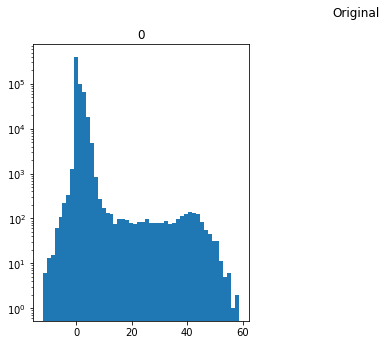

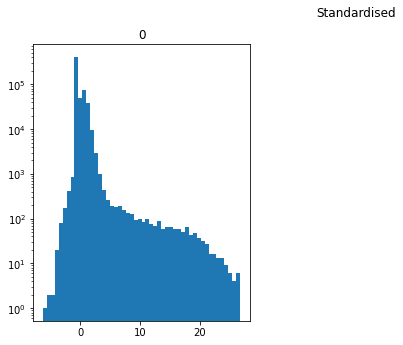

In [14]:
plot_per_sample_histograms(np.expand_dims(input[..., 0], axis=0), title='Original', figsize=(10,5), log=True)
plot_per_sample_histograms(np.expand_dims(std_input[..., 0], axis=0), title='Standardised', figsize=(10,5), log=True)
print('Comparing for a single image')

Applying to whole dataset



In [9]:
images, labels = torch.from_numpy(raw_images), \
                 torch.from_numpy(np.expand_dims(raw_labels, axis=-1))

images.shape, labels.shape




(torch.Size([144, 79, 95, 79, 4]), torch.Size([144, 79, 95, 79, 1]))

In [10]:
std_images = []
std_labels = []

for subj_idx in range(n_subj):
    std_input, std_label = apply_standardisation(images[subj_idx], labels[subj_idx])
    std_images.append(std_input.numpy())
    std_labels.append(std_label.numpy())

std_images = np.array(std_images)
std_labels = np.array(std_labels)

std_images.shape, std_labels.shape



((144, 79, 95, 79, 4), (144, 79, 95, 79, 1))

In [11]:
assert np.all(std_labels == labels.numpy()), 'Labels should be unchanged'

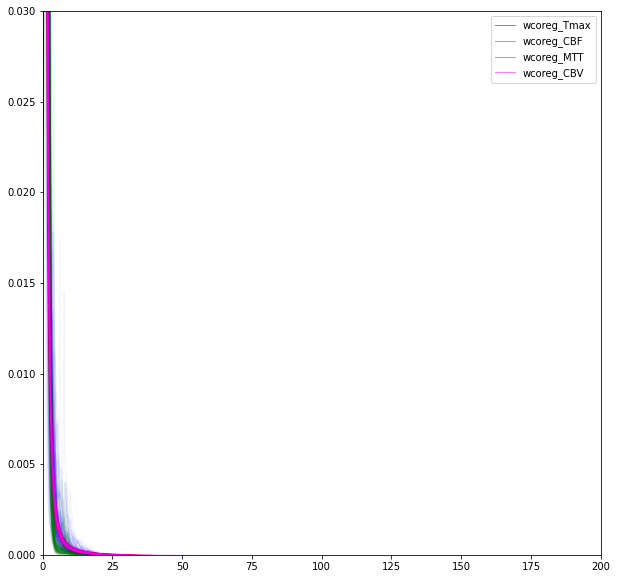

In [12]:
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1)
n_subj, n_x, n_y, n_z, n_c = std_images.shape
color_scheme = ['blue', 'red', 'green', 'magenta']
ct_sequences = params.item()['ct_sequences']

for index, (channel, color, label) in enumerate(zip(range(n_c), color_scheme, ct_sequences)):
    plot_dataset_histogram(std_images[:, ..., channel], num_positions=100, color=color, mask_zero=True, axis=axis,
                           dataset_label=label)
axis.set_xlim(0, 200)
axis.set_ylim(0, 0.03)
leg = axis.legend()
for lh in leg.legendHandles:
    lh.set_alpha(0.5)


Standardized data histograms


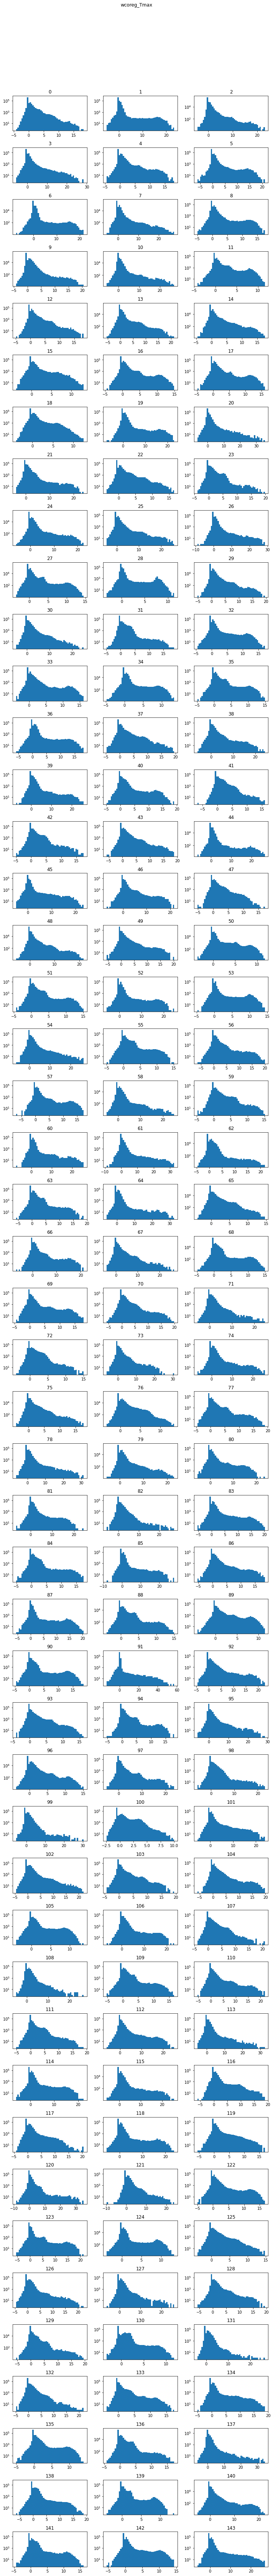

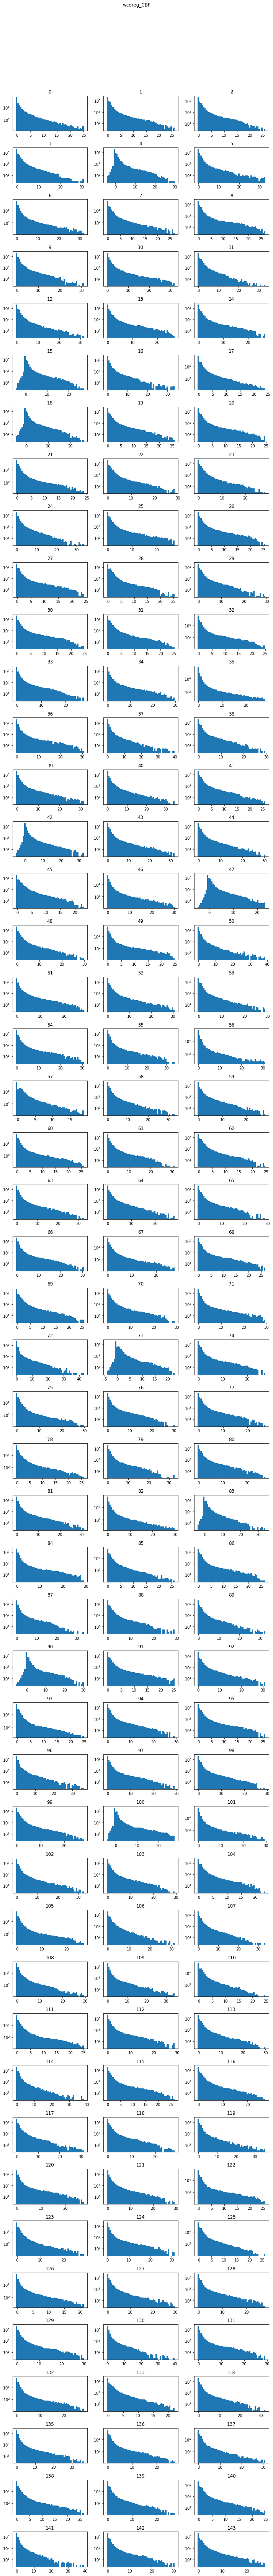

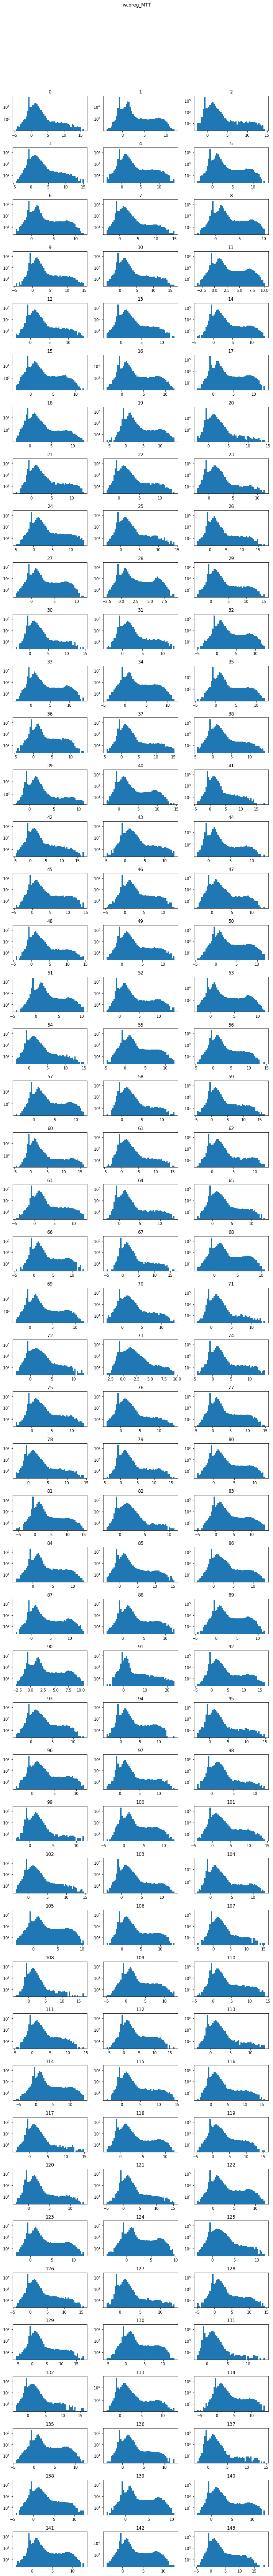

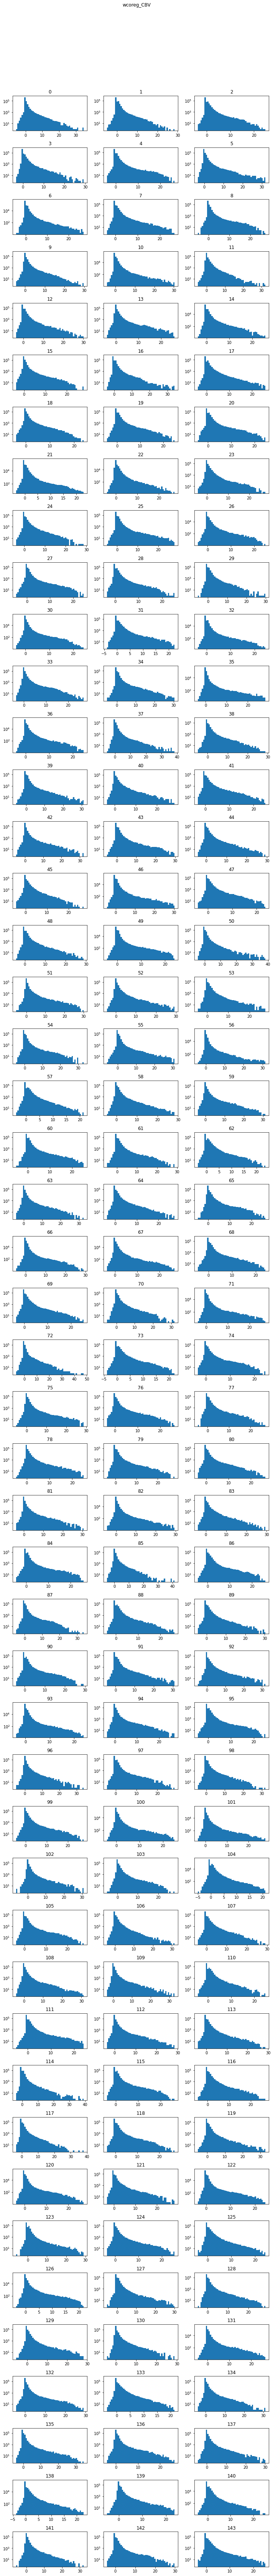

In [13]:
for index, (channel, label) in enumerate(zip(range(n_c), ct_sequences)):
    plot_per_sample_histograms(std_images[..., channel], log=True, title=label, figsize=(10, 100))
print("Per subject standardized data histograms")

### Whole data set standardisation


In [15]:
standardize = lambda x: (x - np.mean(x)) / np.std(x)

In [16]:
std_images = np.empty(raw_images.shape)
for c in range(raw_images.shape[-1]):

    std_images[..., c] = standardize(raw_images[..., c])
    print('CT channel', c, np.mean(std_images[..., c]), np.std(std_images[..., c]))

CT channel 0 5.655627520217011e-16 1.0000000000000036
CT channel 1 1.1375970222263934e-15 1.0000000000000104
CT channel 2 6.33958443369676e-16 1.0000000000000082
CT channel 3 1.0291871083683601e-15 1.000000000000005


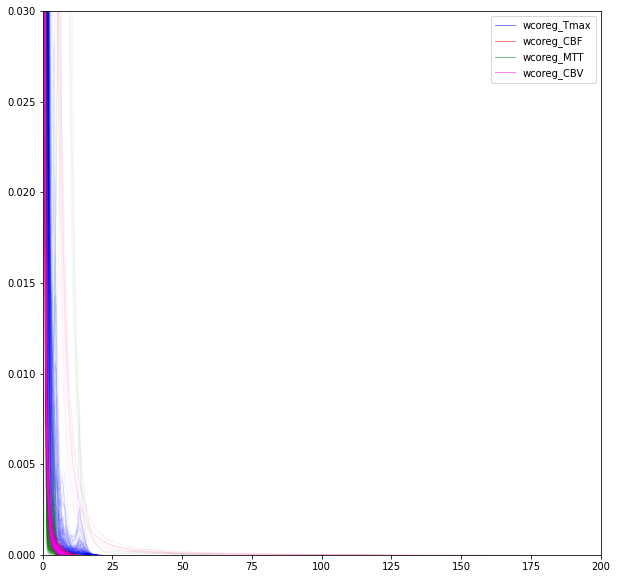

In [17]:
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1)
n_subj, n_x, n_y, n_z, n_c = std_images.shape
color_scheme = ['blue', 'red', 'green', 'magenta']
ct_sequences = params.item()['ct_sequences']

for index, (channel, color, label) in enumerate(zip(range(n_c), color_scheme, ct_sequences)):
    plot_dataset_histogram(std_images[:, ..., channel], num_positions=100, color=color, mask_zero=True, axis=axis,
                           dataset_label=label)
axis.set_xlim(0, 200)
axis.set_ylim(0, 0.03)
leg = axis.legend()
for lh in leg.legendHandles:
    lh.set_alpha(0.5)



All subjects standardized data histograms


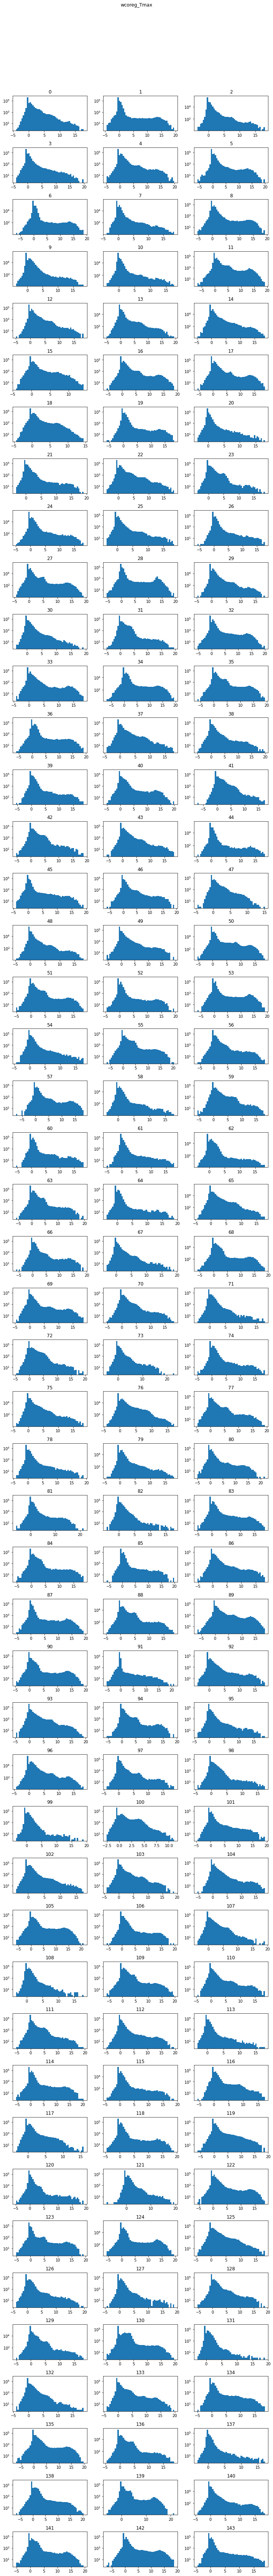

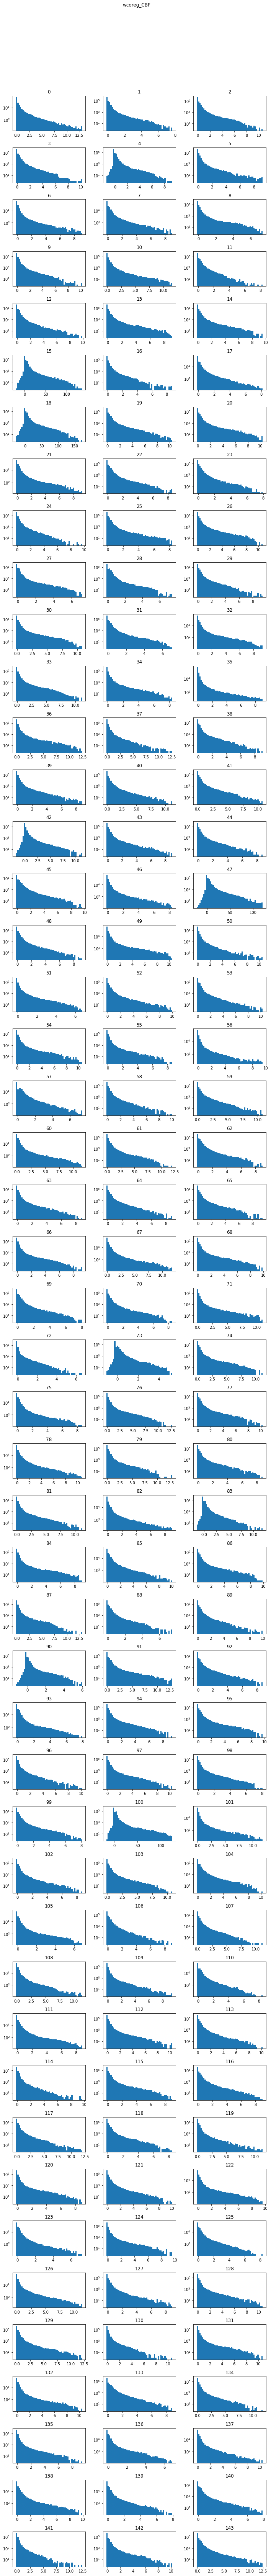

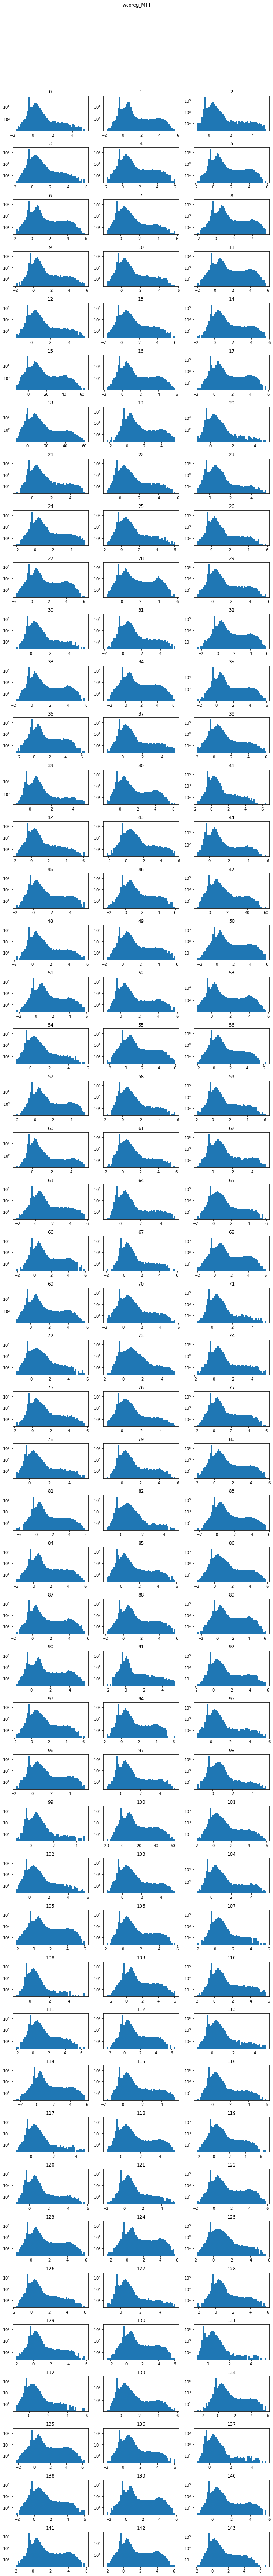

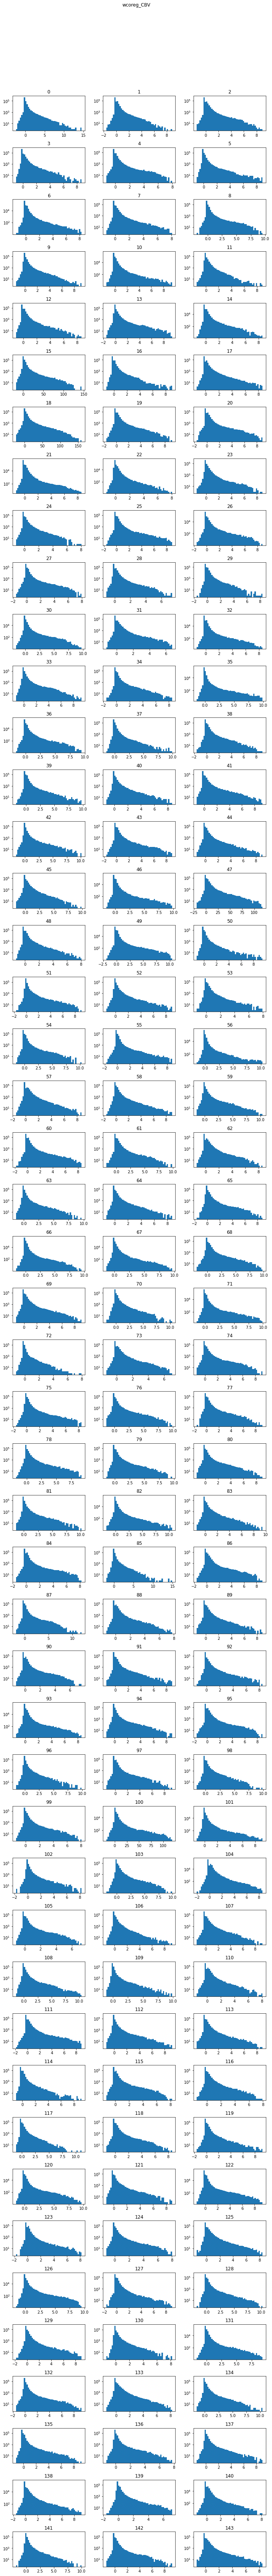

In [18]:
for index, (channel, label) in enumerate(zip(range(n_c), ct_sequences)):
    plot_per_sample_histograms(std_images[..., channel], log=True, title=label, figsize=(10, 100))
print("All subjects standardized data histograms")